##Lab:-1 Linear Regression (Lab Assignment)
Group 9:- 
Maulik Shah, 
Kimaya Shah

In [2]:
#Import the necessary libraries
#For iterative solutions tqdm shows a progress tracker.
import numpy as np 
import pandas as pd 
import math
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt


In [4]:
#Create a class i.e. series of functions to solve the problem.
class LinearRegression:
#The first thing we do after creating a class is to pass Input to the class.
    def __init__(self, X, y, learningRate, maxIteration, epsilon, gd = False, reg = False, sgd = False, 
                 regRate = 0.05):
      
        """
        Parameters:
        X = Data
        y = Target
        learningRate = Learning Rate
        maxIteration = Maximum iterations allowed
        reg = Whether reularization is used in the model, values-(True, False)
        regRate = Rate of regularization i.e. lambda
        """
   
        self.learningRate = learningRate
        self.maxIteration = maxIteration
        self.epsilon = epsilon
        self.X = X
        self.y = y
        self.gd = gd
        self.reg = reg
        self.regRate = regRate
        self.sgd = sgd

    # Dividing the data into training and test data    
        
    def splitData(self):
        """
        There is no need to pass the parameters X and y again, as we already used
        self in the previous function to call the input parameters outside the class.
        """
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=0, 
                                                            shuffle=True)
        return X_train, X_test, y_train, y_test
    
    # Add a column of 1's at the beginning of data to learn the Intercept.

    def add_X0(self,X):
        """
        The conventional linear regression line passes through the origin.It doesn't
        account for the fact if the line starts from somewhere else. Hence we need
        to add an bias/intercept term.
        """
        return np.column_stack([np.ones([X.shape[0],1]),X])
    
    # def plot_Cost(self):
    #     plt.plot(self.error_sequence)
    #     plt.xlabel("Iterations")
    #     plt.ylabel("Cost")
    #     plt.title("Iterations vs cost")
    #     plt.show()
    
    # Normalization of Training and Test data

    def normalizeTrain(self, X):

        """
        Everytime we want to scale data, we do that on training data. save the mean
        and Standard Deviation and then scale the test data with respect to that mean
        and standard deviation.
        """
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X_norm = (X - mean)/ std

        X_norm = self.add_X0(X_norm)
        return X_norm, mean, std
    
    def normalizeTest(self, X, mean, std):
        """
        After normalizing the test data we pass only the testdata in the function 
        fit().
        """

        X_norm = (X - mean)/ std
        X_norm = self.add_X0(X_norm)
        return X_norm
    
    def rank(self, X):
        u,s,vh = np.linalg.svd(X)
        return len([x for x in s if abs(x) > 0])
    
    #Check if the given matrix is full rank or not.

    def checkFullRank(self, X):       #
        rank = self.rank(X)
        if rank == min(X.shape):      
            self.FullRank = True
        else:
            self.FullRank = False
        #return
        
    def checkLowRank(self, X):     
        if X.shape[1] < X.shape[0]:
            self.lowRank = False
        else:
            self.LowRank = True

    def normalEquation(self, X, y, reg):       #closed_form_solution
        if reg == False:
            return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) #weight
        else:
            return np.linalg.inv(X.T.dot(X)-(self.epsilon)*np.eye(X.shape[1])).dot(X.T).dot(y) #weights with regularisation
    
    def predict(self, X):
        return X.dot(self.w)
    
    def sse(self, X, y):
        y_hat = self.predict(X)
        return ((y_hat - y)**2).sum()
    
    def rmse(self, X, y):
        y_hat = self.predict(X)
        return np.sqrt((((y_hat - y)**2)/X.shape[0]).sum())
    
    def costFunction(self, X, y):
        return self.rmse(X, y)/2

    def costDerivative(self, X, y):
        y_hat = self.predict(X)
        if self.reg == False:
            return (y_hat - y).dot(X)
        else:
            return (y_hat - y).dot(X) + (self.regRate * self.w)

    # Using the formula for Gradient descent

    def gradient_descent(self, X,y):
        self.errors = []
        prev_error = float('inf')
        for tq in tqdm(range(self.maxIteration)):
            if self.gd == True: #gradient descent
                self.w = self.w - (self.learningRate * self.costDerivative(X, y))
            elif self.sgd == True: #stochastic gradient descent
                for i in range(0, X.shape[0], 1):   #batchSize = 1
                    X_batch = X[i : i + 1, : ]
                    y_batch = y[i : i + 1]
                    self.w = self.w - (self.learningRate * self.costDerivative(X_batch, y_batch))
            curr_error = self.rmse(X, y)
            diff_error = prev_error - curr_error
            prev_error = curr_error
            self.errors.append(curr_error)
            if diff_error < self.epsilon:
                break 
            self.tq = tq
        self.plot_rmse()
        return self.w
    
    def fit(self):
        self.model =""
        X_train, X_test, y_train, y_test = self.splitData()
        X_train , self.train_mean, self.train_std = self.normalizeTrain(X_train)
        X_test = self.normalizeTest(X_test, self.train_mean, self.train_std)
        
        self.checkFullRank(X_train)
        self.checkLowRank(X_train)

        if self.FullRank == True and not self.lowRank and not self.gd and not self.sgd:
            print("Solving using Closed Normal Equation")
            self.model = "Closed Form "+ "".join(["Regularised" if self.reg==True else "Not-Regularised"])
            
            print()
            print(self.model)
            
            self.w = self.normalEquation(X_train, y_train, self.reg)
            test_rmse = self.rmse(X_test, y_test)
            test_sse = self.sse(X_test, y_test)
            print("RMSE error: ",test_rmse)
            print("SSE error: ", test_sse)

        else:
            print("Solve using Gradient")
            self.model = "" + "".join(["Gradient Descent "if self.gd== True else "Stochastic Gradient Descent "]) + " ".join(["Regularised" if self.reg==True else "Non-Regularised"])
            
            print()
            print(self.model)
            self.w = np.ones(X_train.shape[1], dtype = np.float64)*0
            self.w = self.gradient_descent(X_train, y_train)
            test_rmse = self.rmse(X_test, y_test)
            test_sse = self.sse(X_test, y_test)
            print()
            print("RMSE error: ", test_rmse)
            print("SSE error: ", test_sse)
    

        
    def plot_rmse1(self):
        plt.plot(self.errors)
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        plt.title("Iterations vs cost")
        plt.show()
    
    def plot_rmse(self):
        """
        @X: error_sequence, vector of rmse
        @does: Plots the error function
        @return: plot
        """
        # Data for plotting
        s = np.array(self.errors)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        # ax.set(xlabel='iterations', ylabel=self.errors,
        #        title='{} trend'.format(self.errors))
        ax.grid()

        #plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)
        plt.show()    
    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("housing.csv")
df

,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
501,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
502,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
503,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [6]:
X = df.values[: ,0:-1]
y = df.values[:, -1]

1. Using Normal Equation and learning rate = 0.00001, epsilon = 0.005

In [7]:
clf = LinearRegression(X, y, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = False, reg = False, sgd = False)
clf.fit()

Solving using Closed Normal Equation

Closed Form Not-Regularised
RMSE error:  4.624025082730341
SSE error:  3250.0044107893395


In [8]:
model = LinearRegression(X, y, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = False, reg = True, sgd = False)
model.fit()

Solving using Closed Normal Equation

Closed Form Regularised
RMSE error:  4.624029245398744
SSE error:  3250.010262270038


2. Using Gradient Descent

Solve using Gradient

Gradient Descent Non-Regularised


  2%|▏         | 96/5000 [00:00<00:00, 14169.95it/s]


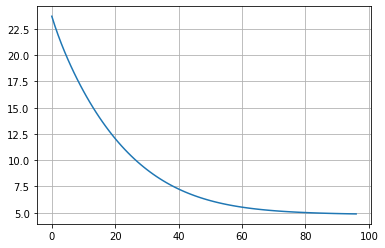


RMSE error:  4.7862705265640235
SSE error:  3482.074604125229


In [9]:
model = LinearRegression(X, y, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = True, reg = False, sgd = False)
model.fit()

Solve using Gradient

Gradient Descent Regularised


  2%|▏         | 96/5000 [00:00<00:00, 15699.82it/s]


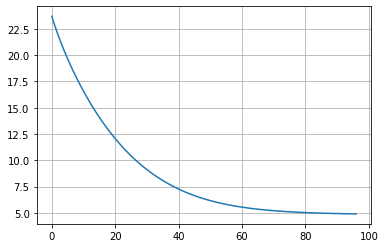


RMSE error:  4.786560722306283
SSE error:  3482.496859345437


In [10]:
model = LinearRegression(X, y, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = True, reg = True, sgd = False)
model.fit()

Solve using Gradient

Stochastic Gradient Descent Non-Regularised


  2%|▏         | 98/5000 [00:00<00:16, 300.38it/s]


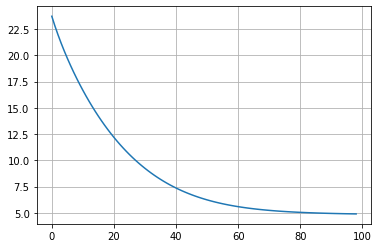


RMSE error:  4.786694996507344
SSE error:  3482.692246417443


In [11]:
model = LinearRegression(X, y, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = False, reg = False, sgd = True)
model.fit()

3. Using Stochiastic Gradient Descent

Solve using Gradient

Stochastic Gradient Descent Regularised


  2%|▏         | 109/5000 [00:00<00:13, 371.33it/s]


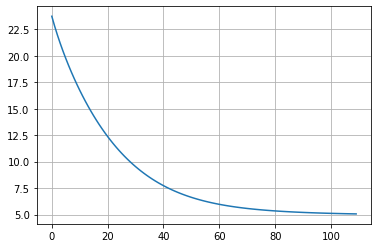


RMSE error:  4.9105034525017786
SSE error:  3665.182711868846


In [12]:
model = LinearRegression(X, y, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = False, reg = True, sgd = True)
model.fit()

# Yacht data set


In [16]:
ydf = pd.read_csv("yachtData (1).csv")
ydf

,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82
...,...,...,...,...,...,...,...
302,-2.3,0.600,4.34,4.23,2.73,0.350,8.47
303,-2.3,0.600,4.34,4.23,2.73,0.375,12.27
304,-2.3,0.600,4.34,4.23,2.73,0.400,19.59
305,-2.3,0.600,4.34,4.23,2.73,0.425,30.48


In [20]:
X_yacht = ydf.values[: ,0:-1]
y_yacht = ydf.values[:, -1]

1. Using Normal Equation and learning rate = 0.001, epsilon = 0.005

In [21]:
clf = LinearRegression(X_yacht, y_yacht, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = False, reg = False, sgd = False)
clf.fit()

Solving using Closed Normal Equation

Closed Form Not-Regularised
RMSE error:  9.051378846467502
SSE error:  7619.25368907198


In [22]:
clf = LinearRegression(X_yacht, y_yacht, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = False, reg = True, sgd = False)
clf.fit()

Solving using Closed Normal Equation

Closed Form Regularised
RMSE error:  9.051472423920854
SSE error:  7619.411232812971


Using Gradient Descent

Solve using Gradient

Gradient Descent Non-Regularised


  2%|▏         | 114/5000 [00:00<00:00, 10735.31it/s]


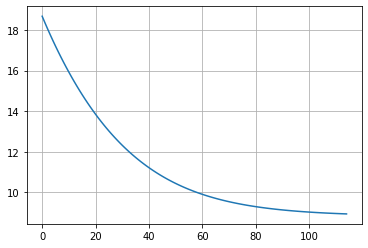


RMSE error:  8.817398171122674
SSE error:  7230.4254772549275


In [23]:
clf = LinearRegression(X_yacht, y_yacht, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = True, reg = False, sgd = False)
clf.fit()

Solve using Gradient

Gradient Descent Regularised


  2%|▏         | 114/5000 [00:00<00:00, 12233.92it/s]


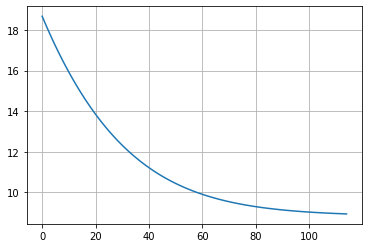


RMSE error:  8.817128126244139
SSE error:  7229.9826006983085


In [24]:
clf = LinearRegression(X_yacht, y_yacht, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = True, reg = True, sgd = False)
clf.fit()

Solve using Gradient

Stochastic Gradient Descent Non-Regularised


  2%|▏         | 114/5000 [00:00<00:06, 715.18it/s]


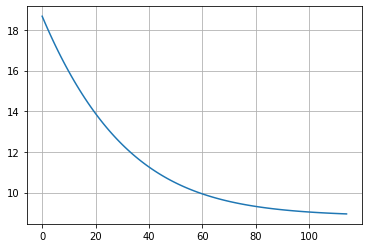


RMSE error:  8.814912160924855
SSE error:  7226.348905648343


In [25]:
clf = LinearRegression(X_yacht, y_yacht, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = False, reg = False, sgd = True)
clf.fit()

Using Stochiastic Gradient Descent

Solve using Gradient

Stochastic Gradient Descent Regularised


  2%|▏         | 120/5000 [00:00<00:15, 313.69it/s]


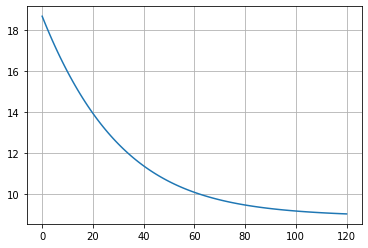


RMSE error:  8.785148913074803
SSE error:  7177.632252515643


In [26]:
clf = LinearRegression(X_yacht, y_yacht, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = False, reg = True, sgd = True)
clf.fit()

# concreteData


In [27]:
cdf = pd.read_csv("concreteData (1).csv")
cdf

,540,0,0.1,162,2.5,1040,676,28,79.99
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
1,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
4,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
...,...,...,...,...,...,...,...,...,...
1024,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1025,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1026,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1027,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [28]:
X_c = cdf.values[: ,0:-1]
y_c = cdf.values[:, -1]

In [29]:
clf = LinearRegression(X_c, y_c, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = False, reg = False, sgd = False)
clf.fit()

Solving using Closed Normal Equation

Closed Form Not-Regularised
RMSE error:  11.106342967100197
SSE error:  38115.413917782505


In [30]:
clf = LinearRegression(X_c, y_c, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = False, reg = True, sgd = False)
clf.fit()

Solving using Closed Normal Equation

Closed Form Regularised
RMSE error:  11.106366258107801
SSE error:  38115.57378090375


Using Gradient Descent

Solve using Gradient

Gradient Descent Non-Regularised


  1%|          | 58/5000 [00:00<00:00, 13793.92it/s]


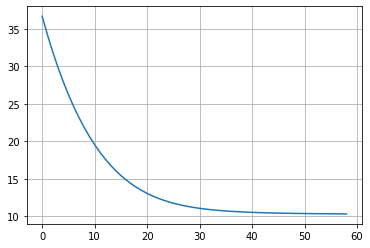


RMSE error:  11.316313774102879
SSE error:  39570.21784709072


In [31]:
clf = LinearRegression(X_c, y_c, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = True, reg = False, sgd = False)
clf.fit()

Solve using Gradient

Gradient Descent Regularised


  1%|          | 58/5000 [00:00<00:00, 20073.41it/s]


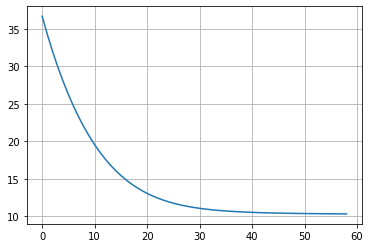


RMSE error:  11.316336930350108
SSE error:  39570.37979005256


In [32]:
clf = LinearRegression(X_c, y_c, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = True, reg = True, sgd = False)
clf.fit()

Solve using Gradient

Stochastic Gradient Descent Non-Regularised


  1%|          | 60/5000 [00:00<00:21, 229.70it/s]


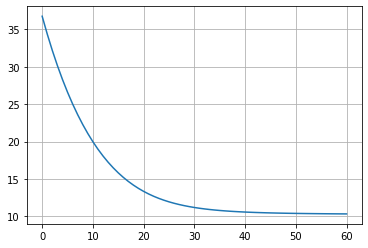


RMSE error:  11.30315477764621
SSE error:  39478.24414957473


In [33]:
clf = LinearRegression(X_c, y_c, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = False, reg = False, sgd = True)
clf.fit()

Using Stochiastic Gradient Descent

Solve using Gradient

Stochastic Gradient Descent Regularised


  1%|▏         | 69/5000 [00:00<00:26, 188.08it/s]


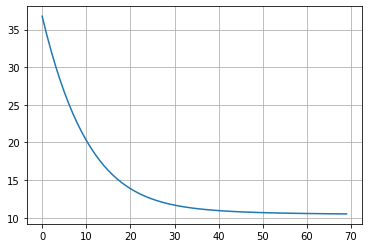


RMSE error:  11.405188720134728
SSE error:  40194.203890243516


In [34]:
clf = LinearRegression(X_c, y_c, learningRate = 0.0001, maxIteration = 5000, epsilon = 0.005, gd = False, reg = True, sgd = True)
clf.fit()

a. For housing dataset Normal Form performs better with less RMSE

b. For Yacht dataset Stochastic Gradient Descent performs better with less RMSE 

c. For Concrete dataset  Gradient Descent performs better with less RMSE

In GD and SGD From the graphs we can see that if the learning rate is high cost function converges quickly and needs minimum iterations but at the same time it gives high cost means while convergin quickly it missed the optimum value of theta. Hence the learning rate should be adjusted the right value of alpha.
With regularization we get less error and also chosing the Normal, Gradient descent and Stochastic GD varies our cost function